## Proba sa spotipy i lyricsgenius

#### import the required libraries

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import lyricsgenius
from bs4 import BeautifulSoup
from selenium import webdriver
from string import punctuation
import nltk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sn
from random import seed
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import re
from sklearn.metrics import silhouette_score

stopword = nltk.corpus.stopwords.words('english')
new_stop_words = ['ooh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa', 'back','said','one', 'come','thing','get','would','like','know','go','let','cause','oh','could','got','uh','ah','lyric','outro']

stopword.extend(new_stop_words)

#### Setting the required data to access the Spotify API

In [3]:
# Setting up the Spotify credentials and authentication scopes
SPOTIPY_CLIENT_ID='c7f3eaa09bd044ffa1c2ca5cdc088aec'
SPOTIPY_CLIENT_SECRET='19f099110ebc43b9808017c6f6cee192'
SPOTIPY_REDIRECT_URI='http://localhost:8888/callback'

scope = ['user-library-read','playlist-modify-public']

# Setting up the Genius API
genius = lyricsgenius.Genius('n-NvJGmw_MU_zTf4eORCJu-IUMhQwl9rCwfBWcdIUppRMjd7tp5YTJ2yh5GfJcSa')

#### Granting access to the public playlists

#### Granting access to all the public playlists and the user's private playlists

In [4]:
# Authenticate the user
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET, redirect_uri=SPOTIPY_REDIRECT_URI, scope=scope))

# Set up the playlist URI or URL
playlist_uri = 'https://open.spotify.com/playlist/47XdQiaIeWaD8xtzK1NXVu?si=bf717264d0b84d5d'

# Get the tracks in the playlist
results = sp.playlist_tracks(playlist_uri)
tracks = results['items']

while results['next']:
    results = sp.next(results)
    tracks.extend(results['items'])

#### Function for retrieving the lyrics of a song

In [5]:
# removing excess info from the track name
def remove_excess_info (x):
    error_words_with_feature=["(with","(feat."]
    error_words_with_feature_2=["[with","[feat."]
    error_words_with_hyphen =["remaster","bonus track","recorded at"," feat. ","- edit", "- video mix","remix"]

    for word in error_words_with_feature_2:
        if word in x.lower():
            x = x.rsplit(" [")[0]
            break
    for word in error_words_with_feature:
        if word in x.lower():
            x = x.rsplit(" (")[0]
            break
    print(x)
    for word in error_words_with_hyphen:
        if word in x.lower():
            x = x.rsplit(" -")[0]

    return x


# Define a function to retrieve the lyrics for a track
def get_lyrics(track_name, artist_name):
    try:

        song = genius.search_song(track_name, artist_name)
        lyrics = song.lyrics
        return lyrics
    except:
        return 'No lyric found'

In [6]:
# Getting the info for the tracks for playlist
track_info = []
for track in tracks:
    track_name = track['track']['name']
    artist_name = track['track']['artists'][0]['name']
    # Retrieving the info about audio features of the track
    audio_features = sp.audio_features(track['track']['id'])[0]
    # Retrieving the lyrics via lyricsgenius library with the function get_lyrics
    info = {'Track Name': track_name, 'Artist Name': artist_name,"Lyrics":get_lyrics(track_name, artist_name)}
    info.update(audio_features)
    track_info.append(info)

# Create a pandas dataframe with the track information
df = pd.DataFrame(track_info)

Searching for "yankee and the brave (ep. 4)" by Run The Jewels...
Done.
Searching for "ooh la la (feat. Greg Nice & DJ Premier)" by Run The Jewels...
Done.
Searching for "out of sight (feat. 2 Chainz)" by Run The Jewels...
Done.
Searching for "holy calamafuck" by Run The Jewels...
Done.
Searching for "goonies vs. E.T." by Run The Jewels...
Done.
Searching for "walking in the snow" by Run The Jewels...
Done.
Searching for "JU$T (feat. Pharrell Williams & Zack de la Rocha)" by Run The Jewels...
Done.
Searching for "never look back" by Run The Jewels...
Done.
Searching for "the ground below" by Run The Jewels...
Done.
Searching for "pulling the pin (feat. Mavis Staples & Josh Homme)" by Run The Jewels...
Done.
Searching for "a few words for the firing squad (radiation)" by Run The Jewels...
Done.
Searching for "recognized" by Kara Jackson...
Done.
Searching for "no fun/party" by Kara Jackson...
Done.
Searching for "dickhead blues" by Kara Jackson...
Done.
Searching for "therapy" by Kara J

#### Retrieving the lyrics via web scraping in case lyricsgenius couldn't find it

In [7]:
def get_soup_selenium(url: str) -> BeautifulSoup:

    driver = webdriver.Chrome()
    driver.get(url)
    return BeautifulSoup(driver.page_source, 'html.parser')

In [8]:
def remove_rows(text):
    text=text.replace("\n"," ")
    return text

def replace_signs(x):
    signs=punctuation + " " + "’"
    x =[c for c in x.lower() if not c in signs]
    x="".join(x)
    return x.strip()


def remove_the(x):
    if "The" in x[0:3]:
        return x.replace("The","").strip()
    if "the" in x[0:3]:
        return x.replace("the","").strip()
    return x

def get_lyrics_selenium(track_name, artist_name):
    try:
        track_name=remove_excess_info(track_name)

        track_name_lc=[w.strip() for w in track_name.lower().split("(") if (not "feat" in w) ]

        if len(track_name_lc)>=1:
            track_name_lc="".join(track_name_lc)
        elif len(track_name_lc)==0:
            track_name_lc=track_name.lower().split(" feat.",maxsplit=1)[0]

        artist_name=remove_the(artist_name)

        url = "https://www.azlyrics.com/lyrics/"+replace_signs(artist_name)+"/"+replace_signs(track_name_lc)+".html"
        print(url)
        soup = get_soup_selenium(url)

        excess="<!-- Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. -->"
        text =str(soup.find("div",{"class":"col-xs-12 col-lg-8 text-center"}).find("div",{"class":None,"style":None}))
        text= text.replace("<br/>","").replace(excess,"").replace("<div>","").replace("</div>","").replace("’","'").strip()


        return remove_rows(text.lower())
    except:
        return 'No lyric found (selenium)'

#### Removing all unnecessary text from the lyrics

In [9]:
def clean_lyrics(artist_name,track_name,lyric):

    track_name = remove_excess_info(track_name)

    #lyric that is retrieved contains some unnecessary information that has to be removed

    if "lyrics[" in lyric:
        lyric = lyric.split("]",maxsplit=1)
    else:
        lyric = lyric.split(track_name+" lyrics",maxsplit=1)

    #if the lyric is retrieved, it would be split into two parts so that the second part represents the real lyric, and the excess info;
    # if it's not, the retrieved text is either "No lyric found" or it is some unuseful text, and it wasn't split in the previous code.
    # Because of that, web scrapping is needed to retrieve the lyric

    if len(lyric)==2:
        lyric = lyric[1]
    else:
        return get_lyrics_selenium(track_name,artist_name)

    lyric=lyric.replace("’","'").replace("embed","").replace("\'","'")

    result = re.sub('\[[^\]]*\W+[^\]]*\]', '', lyric)

    if result[len(result)-1].isnumeric():
        result = result.replace(result[len(result)-1],"")
    return remove_rows(result)

In [10]:
df['clean_lyrics']=df.apply(lambda x: clean_lyrics(x['Artist Name'].lower(),x['Track Name'].lower(),x['Lyrics'].lower()),axis=1)

yankee and the brave (ep. 4)
ooh la la
ooh la la
https://www.azlyrics.com/lyrics/runthejewels/oohlala.html
out of sight
out of sight
https://www.azlyrics.com/lyrics/runthejewels/outofsight.html
holy calamafuck
goonies vs. e.t.
walking in the snow
ju$t
ju$t
https://www.azlyrics.com/lyrics/runthejewels/jut.html
never look back
the ground below
pulling the pin
a few words for the firing squad (radiation)
recognized
no fun/party
dickhead blues
therapy
pawnshop
brain
free
lily
rat
why does the earth give us people to love?
curtains
recognized (reprise)
recognized (reprise)
https://www.azlyrics.com/lyrics/karajackson/recognizedreprise.html
liquor
be quick or be dead - 2015 remaster
be quick or be dead
https://www.azlyrics.com/lyrics/ironmaiden/bequickorbedead.html
from here to eternity - 2015 remaster
from here to eternity
https://www.azlyrics.com/lyrics/ironmaiden/fromheretoeternity.html
afraid to shoot strangers - 2015 remaster
afraid to shoot strangers
https://www.azlyrics.com/lyrics/iron

#### Saving the dataFrame

In [10]:
df.to_csv("playlist.csv",index=False)

In [16]:
df.sample(10)

,Track Name,Artist Name,Lyrics,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,clean_lyrics
99,Money Trees,Kendrick Lamar,514 ContributorsTranslationsTürkçeEnglishFranç...,0.716,0.531,7,-7.355,1,0.1220,0.07030,...,0.344,71.994,audio_features,74tLlkN3rgVzRqQJgPfink,spotify:track:74tLlkN3rgVzRqQJgPfink,https://api.spotify.com/v1/tracks/74tLlkN3rgVz...,https://api.spotify.com/v1/audio-analysis/74tL...,386907,4,"uh, me and my niggas tryna get it, ya bish (y..."
15,Intimidated (feat. H.E.R.),KAYTRANADA,1 ContributorNew Music Friday 11/19/21 LyricsA...,0.738,0.750,11,-3.654,0,0.2190,0.01670,...,0.342,112.009,audio_features,0dFdGPVLs3k0z9ezYWZzUa,spotify:track:0dFdGPVLs3k0z9ezYWZzUa,https://api.spotify.com/v1/tracks/0dFdGPVLs3k0...,https://api.spotify.com/v1/audio-analysis/0dFd...,207840,4,open water just what you wanted so don't leave...
53,Redbone,Childish Gambino,340 ContributorsTranslationsTürkçeEspañolPortu...,0.745,0.353,1,-10.614,1,0.0983,0.17400,...,0.598,160.111,audio_features,0WtDGnWL2KrMCk0mI1Gpwz,spotify:track:0WtDGnWL2KrMCk0mI1Gpwz,https://api.spotify.com/v1/tracks/0WtDGnWL2KrM...,https://api.spotify.com/v1/audio-analysis/0WtD...,326933,4,daylight i wake up feeling like you won't pla...
9,Summer Love,Carly Rae Jepsen,29 ContributorsTranslationsEspañolSummer Love ...,0.703,0.740,2,-5.266,0,0.0336,0.00717,...,0.701,120.026,audio_features,3UK2G7CRI6aYnJyI0Aedl7,spotify:track:3UK2G7CRI6aYnJyI0Aedl7,https://api.spotify.com/v1/tracks/3UK2G7CRI6aY...,https://api.spotify.com/v1/audio-analysis/3UK2...,195987,4,"summer love, wild and free and i'd like to ge..."
42,Gasoline,HAIM,41 ContributorsTranslationsDeutschGasoline Lyr...,0.680,0.714,1,-4.557,0,0.0612,0.06750,...,0.561,133.127,audio_features,5McFvaDjJwpFGk42uo0uYX,spotify:track:5McFvaDjJwpFGk42uo0uYX,https://api.spotify.com/v1/tracks/5McFvaDjJwpF...,https://api.spotify.com/v1/audio-analysis/5McF...,193373,4,you took me back but you shouldn't have now i...
51,Pick Up Your Feelings,Jazmine Sullivan,33 ContributorsTranslationsEspañolPick Up Your...,0.758,0.413,2,-6.239,0,0.0464,0.32100,...,0.599,85.460,audio_features,2I7CJZLo2nDqGuzZJA1XlZ,spotify:track:2I7CJZLo2nDqGuzZJA1XlZ,https://api.spotify.com/v1/tracks/2I7CJZLo2nDq...,https://api.spotify.com/v1/audio-analysis/2I7C...,229413,3,"you said that i've been actin' different, yea..."
103,A BOY IS A GUN*,"Tyler, The Creator",204 ContributorsTranslationsPolskiPortuguêsPol...,0.417,0.689,2,-8.302,0,0.1780,0.57500,...,0.505,79.568,audio_features,1nXZnTALNXiPlvXotqHm66,spotify:track:1nXZnTALNXiPlvXotqHm66,https://api.spotify.com/v1/tracks/1nXZnTALNXiP...,https://api.spotify.com/v1/audio-analysis/1nXZ...,210253,4,"no, don't shoot me down (yeah) no, don't shoo..."
119,Modern Love - 2018 Remaster,David Bowie,3 ContributorsIrrelevant Cabbage’s Ever-Growin...,0.358,0.938,0,-5.577,1,0.0483,0.00375,...,0.944,182.836,audio_features,3gxEZXUjrNbl3TlSrTGbR5,spotify:track:3gxEZXUjrNbl3TlSrTGbR5,https://api.spotify.com/v1/tracks/3gxEZXUjrNbl...,https://api.spotify.com/v1/audio-analysis/3gxE...,288339,4,i know when to go out and when to stay in get ...
29,Your Love Is King,Sade,22 ContributorsYour Love Is King Lyrics[Chorus...,0.742,0.420,9,-6.797,1,0.0310,0.56200,...,0.594,134.624,audio_features,1j2LuIf7mv15ZVug1Xy5qz,spotify:track:1j2LuIf7mv15ZVug1Xy5qz,https://api.spotify.com/v1/tracks/1j2LuIf7mv15...,https://api.spotify.com/v1/audio-analysis/1j2L...,219427,3,"your love is king, crown you in my heart your..."
64,Vroom Vroom,Charli XCX,71 ContributorsVroom Vroom Lyrics[Intro]\nLet'...,0.836,0.684,11,-5.818,1,0.2410,0.12200,...,0.514,151.007,audio_features,5hyq3LBlCfjRQAFkdQwe8o,spotify:track:5hyq3LBlCfjRQAFkdQwe8o,https://api.spotify.com/v1/tracks/5hyq3LBlCfjR...,https://api.spotify.com/v1/audio-analysis/5hyq...,193271,4,let's ride let's ride let's ride let's ride ...


In [11]:
def no_lyrics_songs(df):

    indexes = df.loc[df.clean_lyrics == "No lyric found (selenium)",:].index.tolist()
    print(indexes)
    print(len(indexes))
    df.drop(indexes,inplace=True)
    df.reset_index(inplace=True)

In [12]:
no_lyrics_songs(df)

[22]
1


#### check for the presence of missing values

In [119]:
k_means_columns=["danceability","energy","loudness","acousticness","speechiness","instrumentalness","liveness","valence","tempo","mode","key"]
df[k_means_columns].isna().sum()

danceability        0
energy              0
loudness            0
acousticness        0
speechiness         0
instrumentalness    0
liveness            0
valence             0
tempo               0
mode                0
key                 0
dtype: int64

#### normalization of the audio features columns

In [13]:
def noramlize_feature(x):
    if sum(x)==0:
        return x
    else:
        return (x - min(x))/(max(x) - min(x))

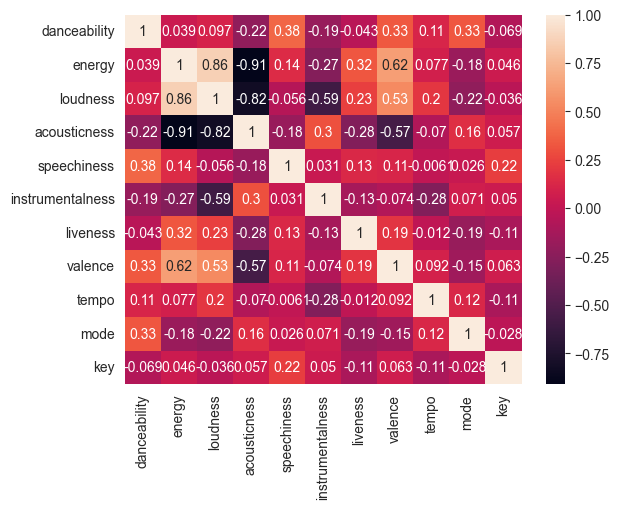

In [121]:
sn.heatmap(df[k_means_columns].corr(), annot=True)
plt.show()

#### removing the highly correlated attributes
without energy and liveness, and also key and mode because they don't contribute to the model

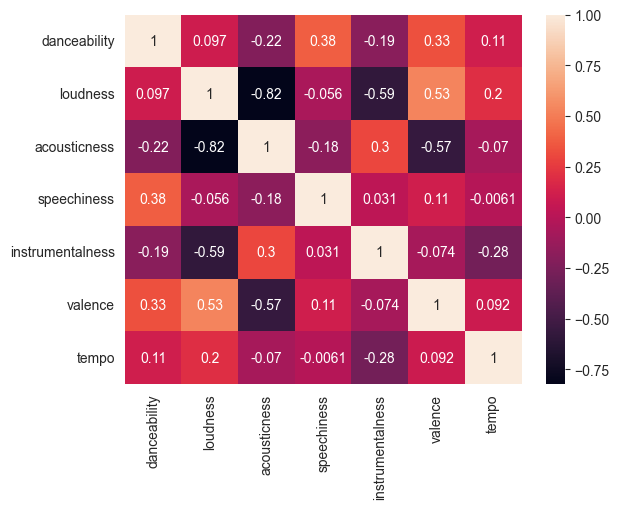

In [14]:
k_means_columns2=["danceability","loudness","acousticness","speechiness","instrumentalness","valence","tempo"]
sn.heatmap(df[k_means_columns2].corr(), annot=True)
plt.show()

In [15]:
songs_normed = df[k_means_columns2].apply(lambda x: noramlize_feature(x))
songs_normed

,danceability,loudness,acousticness,speechiness,instrumentalness,valence,tempo
0,0.583196,0.844686,0.177423,0.862655,0.000000,0.782800,0.063088
1,0.733114,0.857192,0.161941,0.681709,0.000000,0.406836,0.882111
2,0.565074,0.723490,0.018790,0.550905,0.000126,0.715546,0.114644
3,0.596376,0.742278,0.057391,0.566165,0.000000,0.381477,0.415863
4,0.876442,0.707872,0.017345,0.208633,0.000083,0.170893,0.379688
5,0.799012,0.796104,0.062035,0.618487,0.000000,0.296582,0.658244
6,0.723229,0.747868,0.024673,1.000000,0.000766,0.392503,0.531865
7,1.000000,0.662517,0.138203,0.511663,0.001063,0.467475,0.360764
8,0.742998,0.785385,0.001111,0.428821,0.000000,0.404631,0.136972
9,0.373970,0.775761,0.300242,0.524744,0.000011,0.206174,0.240605


#### determining the number of clusters

In [16]:
eval_metrics= pd.DataFrame(columns=["k", "tot.within.ss"])
silhouette=dict()
for k in range(2,16):
    seed(10)

    kmeans= KMeans(n_clusters=k,n_init=1000,max_iter=20)
    kmeans.fit(songs_normed)
    labels=kmeans.labels_

    eval_metrics.loc[len(eval_metrics.index)]=[k,kmeans.inertia_]
    sil=silhouette_score(songs_normed,labels,metric="euclidean",sample_size=1000)
    silhouette.update({k:sil})
    print ("Silhouette score for k(clusters) = "+str(k)+" is "
           +str(round(sil,3)))
print(eval_metrics)
print(max(silhouette,key=silhouette.get))

Silhouette score for k(clusters) = 2 is 0.4
Silhouette score for k(clusters) = 3 is 0.315
Silhouette score for k(clusters) = 4 is 0.355
Silhouette score for k(clusters) = 5 is 0.373
Silhouette score for k(clusters) = 6 is 0.346
Silhouette score for k(clusters) = 7 is 0.338
Silhouette score for k(clusters) = 8 is 0.334
Silhouette score for k(clusters) = 9 is 0.345
Silhouette score for k(clusters) = 10 is 0.342
Silhouette score for k(clusters) = 11 is 0.345
Silhouette score for k(clusters) = 12 is 0.305
Silhouette score for k(clusters) = 13 is 0.288
Silhouette score for k(clusters) = 14 is 0.293
Silhouette score for k(clusters) = 15 is 0.283
       k  tot.within.ss
0    2.0      13.345445
1    3.0      10.170216
2    4.0       8.038288
3    5.0       6.323050
4    6.0       5.438742
5    7.0       4.704249
6    8.0       4.119185
7    9.0       3.544066
8   10.0       3.063828
9   11.0       2.743242
10  12.0       2.471010
11  13.0       2.239137
12  14.0       2.037558
13  15.0       1

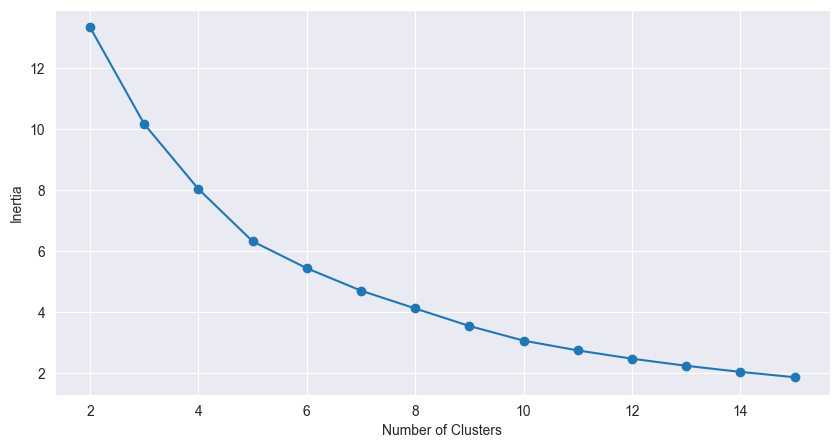

In [16]:
fig = plt.subplots(figsize=(10, 5))
plt.plot(eval_metrics.k, eval_metrics['tot.within.ss'], 'o-')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

In [39]:
df.to_csv("playlist.csv",index=False)

#### kmeans for the best value of cluster

In [17]:
kmeans= KMeans(n_clusters=4,n_init=1000,max_iter=20)
kmeans.fit(songs_normed)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 2, 0])

In [18]:
df["cluster"]=kmeans.labels_
df

,index,Track Name,Artist Name,Lyrics,danceability,energy,key,loudness,mode,speechiness,...,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,clean_lyrics,cluster
0,0,yankee and the brave (ep. 4),Run The Jewels,71 Contributors​yankee and the brave (ep. 4) L...,0.595,0.8780,10,-5.630,0,0.4230,...,82.007,audio_features,1EjzcBTVLV7ATtdsQwyV31,spotify:track:1EjzcBTVLV7ATtdsQwyV31,https://api.spotify.com/v1/tracks/1EjzcBTVLV7A...,https://api.spotify.com/v1/audio-analysis/1Ejz...,146573,4,this week on yankee and the brave stack add...,1
1,1,ooh la la (feat. Greg Nice & DJ Premier),Run The Jewels,2 ContributorsNew Music Friday 3/27/20 LyricsD...,0.686,0.8240,11,-5.413,1,0.3400,...,170.079,audio_features,5taqLrLouA4vCjM7ZQpEtW,spotify:track:5taqLrLouA4vCjM7ZQpEtW,https://api.spotify.com/v1/tracks/5taqLrLouA4v...,https://api.spotify.com/v1/audio-analysis/5taq...,183827,4,"<i>[el-p:]</i> uh, hey (oh, shit) ooh, la la, ...",1
2,2,out of sight (feat. 2 Chainz),Run The Jewels,2 ContributorsNew Music Friday 06/05/20 Lyrics...,0.584,0.7220,9,-7.733,1,0.2800,...,87.551,audio_features,2uxudaBcJamtfgvUjSDdkZ,spotify:track:2uxudaBcJamtfgvUjSDdkZ,https://api.spotify.com/v1/tracks/2uxudaBcJamt...,https://api.spotify.com/v1/audio-analysis/2uxu...,201133,4,"ayy, ayy ru-ru-run-run, here come the menace,...",1
3,3,holy calamafuck,Run The Jewels,98 Contributors​holy calamafuck Lyrics[Intro: ...,0.603,0.7640,7,-7.407,1,0.2870,...,119.942,audio_features,6tfrMstZ8tw7nZJ6HP0PyW,spotify:track:6tfrMstZ8tw7nZJ6HP0PyW,https://api.spotify.com/v1/tracks/6tfrMstZ8tw7...,https://api.spotify.com/v1/audio-analysis/6tfr...,238413,4,"all them-a talk, them beat back them words al...",1
4,4,goonies vs. E.T.,Run The Jewels,61 Contributors​goonies vs. E.T. Lyrics[Intro:...,0.773,0.6100,2,-8.004,1,0.1230,...,116.052,audio_features,3tDIjnh6wdwMWDHRHF97XC,spotify:track:3tDIjnh6wdwMWDHRHF97XC,https://api.spotify.com/v1/tracks/3tDIjnh6wdwM...,https://api.spotify.com/v1/audio-analysis/3tDI...,183173,4,"baby, if i had another chance, i would give a...",1
5,5,walking in the snow,Run The Jewels,118 ContributorsTranslationsРусский​walking in...,0.726,0.8180,0,-6.473,1,0.3110,...,146.006,audio_features,2pVvB487ZwqdzTxEvEEors,spotify:track:2pVvB487ZwqdzTxEvEEors,https://api.spotify.com/v1/tracks/2pVvB487Zwqd...,https://api.spotify.com/v1/audio-analysis/2pVv...,235867,4,"get a dose, a dirty code to go, been cold sin...",1
6,6,JU$T (feat. Pharrell Williams & Zack de la Rocha),Run The Jewels,2 ContributorsNew Music Friday 06/05/20 Lyrics...,0.680,0.5010,6,-7.310,0,0.4860,...,132.416,audio_features,10vS4ZLi4XWlIsNXSQXgqh,spotify:track:10vS4ZLi4XWlIsNXSQXgqh,https://api.spotify.com/v1/tracks/10vS4ZLi4XWl...,https://api.spotify.com/v1/audio-analysis/10vS...,205160,4,mastered economics 'cause you took yourself fr...,1
7,7,never look back,Run The Jewels,43 Contributors​never look back Lyrics[Verse 1...,0.848,0.7210,1,-8.791,1,0.2620,...,114.017,audio_features,3vrOmd6lTTKXGjaYeq8kni,spotify:track:3vrOmd6lTTKXGjaYeq8kni,https://api.spotify.com/v1/tracks/3vrOmd6lTTKX...,https://api.spotify.com/v1/audio-analysis/3vrO...,177187,4,"eighty-one miles to the hour down road (uh, u...",1
8,8,the ground below,Run The Jewels,59 Contributors​the ground below Lyrics[Intro:...,0.692,0.7850,7,-6.659,1,0.2240,...,89.952,audio_features,30gsURaHDTPnDJDINiTCsK,spotify:track:30gsURaHDTPnDJDINiTCsK,https://api.spotify.com/v1/tracks/30gsURaHDTPn...,https://api.spotify.com/v1/audio-analysis/30gs...,152213,4,"rtj, the god! you say that you don't love m...",1
9,9,pulling the pin (feat. Mavis Staples & Josh Ho...,Run The Jewels,57 Contributors​pulling the pin Lyrics[Intro]\...,0.468,0.7630,9,-6.826,0,0.2680,...,101.096,audio_features,1uE4PBDSPZ0cT4do1bmT7A,spotify:track:1uE4PBDSPZ0cT4do1bmT7A,https://api.spotify.com/v1/tracks/1uE4PBDSPZ0c...,https://api.spotify.com/v1/audio-analysis/1uE4...,217240,3,"yeah yeah, that cash yeah, take it, here an...",1


In [23]:
df.to_csv("playlist.csv",index=False)

#### tf-idf vectorization

In [19]:
vectorizer=TfidfVectorizer(stop_words=stopword, min_df=0.1)
tfidf= vectorizer.fit_transform(df["clean_lyrics"])

#### topic modeling - NMF method

In [20]:
number_of_topics=4

In [21]:
from sklearn.decomposition import NMF
nmf=NMF(n_components=number_of_topics)
topic_values= nmf.fit_transform(tfidf)

creating wordclouds for topics

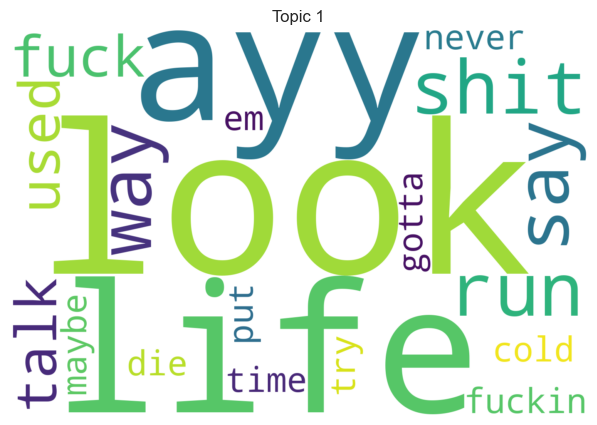

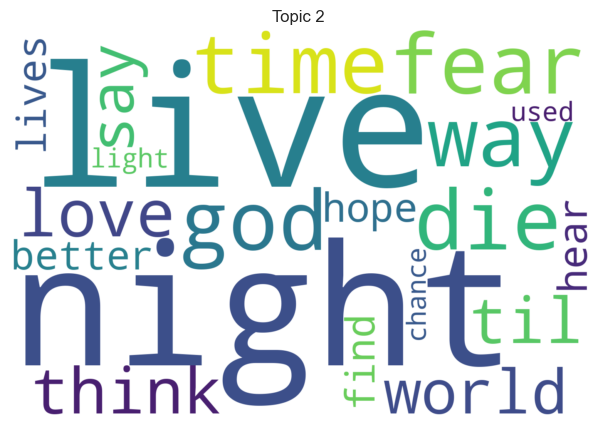

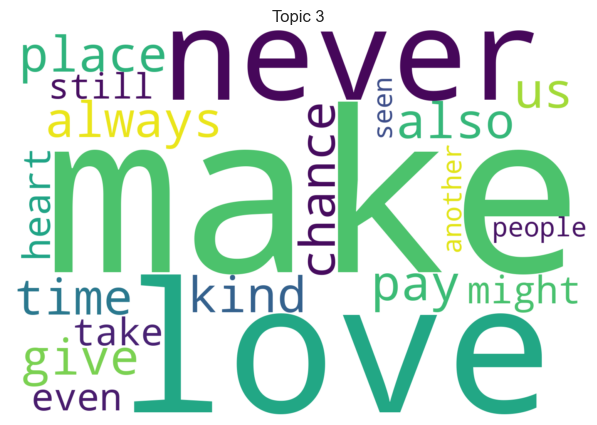

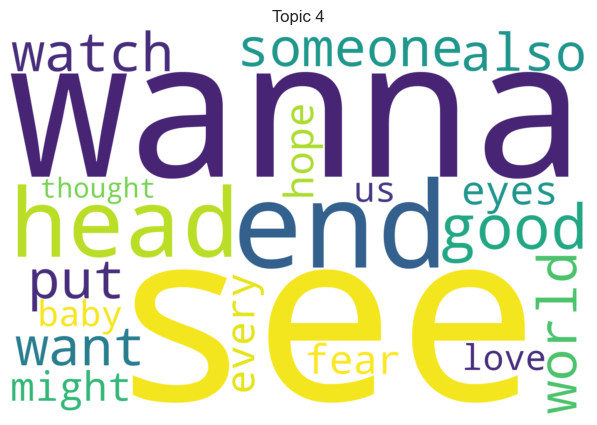

In [22]:
from wordcloud import WordCloud


feature_names = vectorizer.get_feature_names_out()

topic_words = []
for topic_idx, topic in enumerate(nmf.components_):
    top_words_idx = topic.argsort()[:-21:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    topic_words.append(top_words)

# Step 3: Prepare word frequencies
for i, words in enumerate(topic_words):
    word_frequencies = {word: i+1 for word in words}

    # Generate word cloud
    wordcloud = WordCloud(width=1500, height=1000, background_color='white').generate_from_frequencies(word_frequencies)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {i+1}")
    plt.axis('off')
    plt.show()

In [23]:
df=df.join(pd.DataFrame(topic_values,columns=["topic_1","topic_2","topic_3","topic_4"]))

In [48]:
df

,index,Track Name,Artist Name,Lyrics,danceability,energy,key,loudness,mode,speechiness,...,track_href,analysis_url,duration_ms,time_signature,clean_lyrics,cluster,topic_1,topic_2,topic_3,topic_4
0,0,yankee and the brave (ep. 4),Run The Jewels,71 Contributors​yankee and the brave (ep. 4) L...,0.595,0.8780,10,-5.630,0,0.4230,...,https://api.spotify.com/v1/tracks/1EjzcBTVLV7A...,https://api.spotify.com/v1/audio-analysis/1Ejz...,146573,4,this week on yankee and the brave stack add...,2,0.238499,0.017399,0.050339,0.047282
1,1,ooh la la (feat. Greg Nice & DJ Premier),Run The Jewels,2 ContributorsNew Music Friday 3/27/20 LyricsD...,0.686,0.8240,11,-5.413,1,0.3400,...,https://api.spotify.com/v1/tracks/5taqLrLouA4v...,https://api.spotify.com/v1/audio-analysis/5taq...,183827,4,"<i>[el-p:]</i> uh, hey (oh, shit) ooh, la la, ...",2,0.371557,0.000000,0.000000,0.077042
2,2,out of sight (feat. 2 Chainz),Run The Jewels,2 ContributorsNew Music Friday 06/05/20 Lyrics...,0.584,0.7220,9,-7.733,1,0.2800,...,https://api.spotify.com/v1/tracks/2uxudaBcJamt...,https://api.spotify.com/v1/audio-analysis/2uxu...,201133,4,"ayy, ayy ru-ru-run-run, here come the menace,...",2,0.308800,0.000000,0.000000,0.100734
3,3,holy calamafuck,Run The Jewels,98 Contributors​holy calamafuck Lyrics[Intro: ...,0.603,0.7640,7,-7.407,1,0.2870,...,https://api.spotify.com/v1/tracks/6tfrMstZ8tw7...,https://api.spotify.com/v1/audio-analysis/6tfr...,238413,4,"all them-a talk, them beat back them words al...",2,0.313168,0.000000,0.060996,0.000000
4,4,goonies vs. E.T.,Run The Jewels,61 Contributors​goonies vs. E.T. Lyrics[Intro:...,0.773,0.6100,2,-8.004,1,0.1230,...,https://api.spotify.com/v1/tracks/3tDIjnh6wdwM...,https://api.spotify.com/v1/audio-analysis/3tDI...,183173,4,"baby, if i had another chance, i would give a...",2,0.180528,0.000000,0.192145,0.017203
5,5,walking in the snow,Run The Jewels,118 ContributorsTranslationsРусский​walking in...,0.726,0.8180,0,-6.473,1,0.3110,...,https://api.spotify.com/v1/tracks/2pVvB487Zwqd...,https://api.spotify.com/v1/audio-analysis/2pVv...,235867,4,"get a dose, a dirty code to go, been cold sin...",2,0.214521,0.000000,0.030686,0.000000
6,6,JU$T (feat. Pharrell Williams & Zack de la Rocha),Run The Jewels,2 ContributorsNew Music Friday 06/05/20 Lyrics...,0.680,0.5010,6,-7.310,0,0.4860,...,https://api.spotify.com/v1/tracks/10vS4ZLi4XWl...,https://api.spotify.com/v1/audio-analysis/10vS...,205160,4,mastered economics 'cause you took yourself fr...,2,0.353483,0.000000,0.031257,0.039316
7,7,never look back,Run The Jewels,43 Contributors​never look back Lyrics[Verse 1...,0.848,0.7210,1,-8.791,1,0.2620,...,https://api.spotify.com/v1/tracks/3vrOmd6lTTKX...,https://api.spotify.com/v1/audio-analysis/3vrO...,177187,4,"eighty-one miles to the hour down road (uh, u...",2,0.200979,0.000000,0.172983,0.000000
8,8,the ground below,Run The Jewels,59 Contributors​the ground below Lyrics[Intro:...,0.692,0.7850,7,-6.659,1,0.2240,...,https://api.spotify.com/v1/tracks/30gsURaHDTPn...,https://api.spotify.com/v1/audio-analysis/30gs...,152213,4,"rtj, the god! you say that you don't love m...",2,0.129827,0.052333,0.373577,0.000000
9,9,pulling the pin (feat. Mavis Staples & Josh Ho...,Run The Jewels,57 Contributors​pulling the pin Lyrics[Intro]\...,0.468,0.7630,9,-6.826,0,0.2680,...,https://api.spotify.com/v1/tracks/1uE4PBDSPZ0c...,https://api.spotify.com/v1/audio-analysis/1uE4...,217240,3,"yeah yeah, that cash yeah, take it, here an...",2,0.014971,0.000000,0.154733,0.056426


#### deciding which topic has influence on a song

In [24]:
for i in range(1,5):
    column_name="topic_"+str(i)
    df.loc[df[column_name]>=0.09,i]=True
    df.loc[df[column_name]<0.09,i]=False

In [57]:
df

,index,Track Name,Artist Name,Lyrics,danceability,energy,key,loudness,mode,speechiness,...,clean_lyrics,cluster,topic_1,topic_2,topic_3,topic_4,1,2,3,4
0,0,yankee and the brave (ep. 4),Run The Jewels,71 Contributors​yankee and the brave (ep. 4) L...,0.595,0.8780,10,-5.630,0,0.4230,...,this week on yankee and the brave stack add...,2,0.238499,0.017399,0.050339,0.047282,True,False,False,False
1,1,ooh la la (feat. Greg Nice & DJ Premier),Run The Jewels,2 ContributorsNew Music Friday 3/27/20 LyricsD...,0.686,0.8240,11,-5.413,1,0.3400,...,"<i>[el-p:]</i> uh, hey (oh, shit) ooh, la la, ...",2,0.371557,0.000000,0.000000,0.077042,True,False,False,False
2,2,out of sight (feat. 2 Chainz),Run The Jewels,2 ContributorsNew Music Friday 06/05/20 Lyrics...,0.584,0.7220,9,-7.733,1,0.2800,...,"ayy, ayy ru-ru-run-run, here come the menace,...",2,0.308800,0.000000,0.000000,0.100734,True,False,False,True
3,3,holy calamafuck,Run The Jewels,98 Contributors​holy calamafuck Lyrics[Intro: ...,0.603,0.7640,7,-7.407,1,0.2870,...,"all them-a talk, them beat back them words al...",2,0.313168,0.000000,0.060996,0.000000,True,False,False,False
4,4,goonies vs. E.T.,Run The Jewels,61 Contributors​goonies vs. E.T. Lyrics[Intro:...,0.773,0.6100,2,-8.004,1,0.1230,...,"baby, if i had another chance, i would give a...",2,0.180528,0.000000,0.192145,0.017203,True,False,True,False
5,5,walking in the snow,Run The Jewels,118 ContributorsTranslationsРусский​walking in...,0.726,0.8180,0,-6.473,1,0.3110,...,"get a dose, a dirty code to go, been cold sin...",2,0.214521,0.000000,0.030686,0.000000,True,False,False,False
6,6,JU$T (feat. Pharrell Williams & Zack de la Rocha),Run The Jewels,2 ContributorsNew Music Friday 06/05/20 Lyrics...,0.680,0.5010,6,-7.310,0,0.4860,...,mastered economics 'cause you took yourself fr...,2,0.353483,0.000000,0.031257,0.039316,True,False,False,False
7,7,never look back,Run The Jewels,43 Contributors​never look back Lyrics[Verse 1...,0.848,0.7210,1,-8.791,1,0.2620,...,"eighty-one miles to the hour down road (uh, u...",2,0.200979,0.000000,0.172983,0.000000,True,False,True,False
8,8,the ground below,Run The Jewels,59 Contributors​the ground below Lyrics[Intro:...,0.692,0.7850,7,-6.659,1,0.2240,...,"rtj, the god! you say that you don't love m...",2,0.129827,0.052333,0.373577,0.000000,True,False,True,False
9,9,pulling the pin (feat. Mavis Staples & Josh Ho...,Run The Jewels,57 Contributors​pulling the pin Lyrics[Intro]\...,0.468,0.7630,9,-6.826,0,0.2680,...,"yeah yeah, that cash yeah, take it, here an...",2,0.014971,0.000000,0.154733,0.056426,False,False,True,False


In [25]:
number_of_clusters=len(set(df.cluster.values))

#### creating a dictionary based on the cluster and the topic that a song belongs to
if a song is clustered to 1st cluster and is highly influenced by the 2nd topic, it would be added to dict with key value "1_2" (1 - number of cluster, 2 - topic number)

In [26]:
songs_per_cluster_topics=defaultdict(list)

def check_topic(row):
    for i in range (1,5):
        cluster_str=str(row['cluster']+1) + "_" +str(i)

        if row[i]:
            songs_per_cluster_topics[cluster_str].append(row['id'])

df.apply(check_topic,axis=1)

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
30    None
31    None
32    None
33    None
34    None
35    None
36    None
37    None
38    None
39    None
40    None
41    None
42    None
43    None
44    None
45    None
46    None
dtype: object

In [54]:
songs_per_cluster_topics_name=defaultdict(list)

def check_topic(row):
    for i in range (1,5):
        cluster_str=str(row['cluster']+1) + "_" +str(i)

        if row[i]:
            songs_per_cluster_topics_name[cluster_str].append(row['Track Name'])

df.apply(check_topic,axis=1)

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
30    None
31    None
32    None
33    None
34    None
35    None
36    None
37    None
38    None
39    None
40    None
41    None
42    None
43    None
44    None
45    None
46    None
dtype: object

In [55]:
songs_per_cluster_topics_name

defaultdict(list,
            {'3_1': ['yankee and the brave (ep. 4)',
              'ooh la la (feat. Greg Nice & DJ Premier)',
              'out of sight (feat. 2 Chainz)',
              'holy calamafuck',
              'goonies vs. E.T.',
              'walking in the snow',
              'JU$T (feat. Pharrell Williams & Zack de la Rocha)',
              'never look back',
              'the ground below'],
             '3_4': ['out of sight (feat. 2 Chainz)'],
             '3_3': ['goonies vs. E.T.',
              'never look back',
              'the ground below',
              'pulling the pin (feat. Mavis Staples & Josh Homme)'],
             '4_1': ['a few words for the firing squad (radiation)',
              'Weekend Warrior - 2015 Remaster',
              'Pearl'],
             '4_3': ['a few words for the firing squad (radiation)',
              'From Here to Eternity - 2015 Remaster',
              'The Fugitive - 2015 Remaster',
              'Chains of Misery - 2015 Re

In [53]:
songs_per_cluster_topics

defaultdict(list,
            {'3_1': ['1EjzcBTVLV7ATtdsQwyV31',
              '5taqLrLouA4vCjM7ZQpEtW',
              '2uxudaBcJamtfgvUjSDdkZ',
              '6tfrMstZ8tw7nZJ6HP0PyW',
              '3tDIjnh6wdwMWDHRHF97XC',
              '2pVvB487ZwqdzTxEvEEors',
              '10vS4ZLi4XWlIsNXSQXgqh',
              '3vrOmd6lTTKXGjaYeq8kni',
              '30gsURaHDTPnDJDINiTCsK'],
             '3_4': ['2uxudaBcJamtfgvUjSDdkZ'],
             '3_3': ['3tDIjnh6wdwMWDHRHF97XC',
              '3vrOmd6lTTKXGjaYeq8kni',
              '30gsURaHDTPnDJDINiTCsK',
              '1uE4PBDSPZ0cT4do1bmT7A'],
             '4_1': ['1hxVQkhDJN2UnkgeqX68D3',
              '1p3VX4AHb54jMpVJmVNBQG',
              '1JVwGAWkuF1bhHX6eZdcEH'],
             '4_3': ['1hxVQkhDJN2UnkgeqX68D3',
              '6uXD7ywanNw6sGatkT9uVw',
              '3RMlIPEzFLbcEQwUFw2VA5',
              '28JhcFgvq6WIHDosOSou4K'],
             '2_2': ['1HoSyT8MIKRUZ3q3ohEFiK'],
             '2_3': ['1HoSyT8MIKRUZ3q3ohEFiK',
       

#### creating the playlists

In [27]:
k = 0
for i in range(1,number_of_clusters+1):
    for topic_num, topic in enumerate(nmf.components_):

        user_id = sp.me()['id']
        # add tracks to playlist
        playlist_from_dict=str(i)+"_"+str(topic_num+1)

        track_ids = songs_per_cluster_topics[playlist_from_dict]
        if len(track_ids)>2:
            k=k+1
            playlist_name = f'PANDAS My Playlist number {k}'
            playlist_description = f'A playlist created using Python and Spotipy. It is based on cluster {i}, and the main topics of the songs are based on words such as: {" ".join([vectorizer.get_feature_names_out()[i]for i in topic.argsort()[:-11:-1]])}'
            display(playlist_description)
            playlist = sp.user_playlist_create(user_id, playlist_name, public=True, description=playlist_description)

            sp.user_playlist_add_tracks(user_id, playlist['id'], track_ids)



'A playlist created using Python and Spotipy. It is based on cluster 1, and the main topics of the songs are based on words such as: make love never always give chance place also time pay'

'A playlist created using Python and Spotipy. It is based on cluster 1, and the main topics of the songs are based on words such as: see wanna end head good watch someone want world put'

'A playlist created using Python and Spotipy. It is based on cluster 2, and the main topics of the songs are based on words such as: look life ayy shit run say way fuck used talk'

'A playlist created using Python and Spotipy. It is based on cluster 2, and the main topics of the songs are based on words such as: make love never always give chance place also time pay'

'A playlist created using Python and Spotipy. It is based on cluster 3, and the main topics of the songs are based on words such as: look life ayy shit run say way fuck used talk'

'A playlist created using Python and Spotipy. It is based on cluster 3, and the main topics of the songs are based on words such as: make love never always give chance place also time pay'

'A playlist created using Python and Spotipy. It is based on cluster 3, and the main topics of the songs are based on words such as: see wanna end head good watch someone want world put'

'A playlist created using Python and Spotipy. It is based on cluster 4, and the main topics of the songs are based on words such as: look life ayy shit run say way fuck used talk'

'A playlist created using Python and Spotipy. It is based on cluster 4, and the main topics of the songs are based on words such as: night live fear way god time die love think til'

'A playlist created using Python and Spotipy. It is based on cluster 4, and the main topics of the songs are based on words such as: make love never always give chance place also time pay'

'A playlist created using Python and Spotipy. It is based on cluster 4, and the main topics of the songs are based on words such as: see wanna end head good watch someone want world put'

summary stats for given clusters

In [28]:
import numpy as np

def summary_stats(feature_set, clusters, cl_num):
    sum_stats = feature_set.groupby(clusters).agg(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.sqrt(np.var(x)), 2)) + ")")
    value_counts = pd.Series(clusters).value_counts().sort_index()

    sum_stats["freq"]=value_counts.values
    sum_stats.reset_index(inplace=True)
    sum_stats.rename(columns={'index': 'clusters'},inplace=True)
    sum_stats = sum_stats.transpose()
    sum_stats.columns = ['Mean (SD)' for i in range(cl_num)]

    return sum_stats

In [29]:
summary_stats(songs_normed,kmeans.labels_,4)

,Mean (SD),Mean (SD),Mean (SD),Mean (SD)
clusters,0,1,2,3
danceability,0.34 (0.16),0.7 (0.17),0.73 (0.12),0.17 (0.16)
loudness,0.52 (0.19),0.76 (0.06),0.92 (0.06),0.88 (0.06)
acousticness,0.83 (0.12),0.1 (0.09),0.03 (0.04),0.01 (0.03)
speechiness,0.06 (0.11),0.6 (0.21),0.06 (0.05),0.05 (0.03)
instrumentalness,0.13 (0.3),0.0 (0.0),0.0 (0.0),0.05 (0.1)
valence,0.2 (0.13),0.42 (0.19),0.71 (0.16),0.42 (0.2)
tempo,0.35 (0.32),0.38 (0.25),0.48 (0.12),0.4 (0.23)
freq,13,10,11,13
